### Authentification & initial params

In [ ]:
# TO BE DONE IN GOOGLE COLAB

# !git clone https://github.com/TheChwal/forest_guard.git

# %cd forest_guard/

# !pip install .

In [ ]:
!git clone https://github.com/TheChwal/forest_guard.git

Cloning into 'forest_guard'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 251 (delta 150), reused 236 (delta 137), pack-reused 0
Receiving objects: 100% (251/251), 12.17 MiB | 22.82 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [ ]:
%cd forest_guard/

/content/forest_guard


In [ ]:
!pip install .

Processing /content/forest_guard
     |████████████████████████████████| 143kB 3.7MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 194kB 17.8MB/s 
     |████████████████████████████████| 14.2MB 286kB/s 
     |████████████████████████████████| 19.3MB 1.4MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 727kB 37.2MB/s 
     |████████████████████████████████| 747kB 24.9MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 112kB 52.7MB/s 
     |████████████████████████████████| 1.3MB 38.4MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 174kB 48.7MB/s 
     |████████████████████████████████| 153kB 31.6MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 1.1MB 38.8MB/s 
     |██████████████████████

In [ ]:
import ee 
import folium
from datetime import datetime as dt
from IPython.display import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from google.cloud import storage
import time
import numpy as np
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import metrics
from tensorflow.python.keras import optimizers

In [ ]:
#TO BE DONE IN GOOGLE COLAB

from google.colab import auth

In [ ]:
auth.authenticate_user()

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=uCJGJHMztEfwxMbXNO-dqmnX9eGz8zgvbrnlot47p8c&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7jopnIea8dPD90tY47vqMrzxwHLLHq6eD69KaQPM4iouNxrs5J_dk

Successfully saved authorization token.


In [ ]:
import os
from google.cloud import storage

BUCKET = 'forest_guard_bucket'  # ⚠️ replace with your BUCKET NAME
FOLDER = 'JP_prediction'
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

OPTICAL_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
THERMAL_BANDS = ['B10', 'B11']
BANDS = OPTICAL_BANDS + THERMAL_BANDS
RESPONSE = 'fnf'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Specify model training parameters.
#BATCH_SIZE = 16
# EPOCHS = 10
#BUFFER_SIZE = 2000
# OPTIMIZER = 'SGD'
# LOSS = 'MeanSquaredError'
# METRICS = ['RootMeanSquaredError']

In [ ]:
from forest_guard.datas import get_image_landsat

image_2018 = get_image_landsat('2018-01-01', '2018-12-31')
image_2019 = get_image_landsat('2019-01-01', '2019-12-31')
image_2020 = get_image_landsat('2020-01-01', '2020-12-31')

In [ ]:
from forest_guard.datas import get_jaxa

jaxa = get_jaxa('2017-01-01', '2017-12-31')

In [ ]:
from forest_guard.datas import get_stacked_arrays

arrays_2018 = get_stacked_arrays(image_2019, jaxa, BANDS, RESPONSE, KERNEL_SIZE)
arrays_2019 = get_stacked_arrays(image_2019, jaxa, BANDS, RESPONSE, KERNEL_SIZE)
arrays_2020 = get_stacked_arrays(image_2020, jaxa, BANDS, RESPONSE, KERNEL_SIZE)

### Download predict image

In [ ]:
#Predict parameters

user_folder = 'users/bastidearthur' # replace 'username' by your GEE username (https://code.earthengine.google.com/ => Assets)
predict_image = 'france_mont_de_marsan_2018' #precise zone + model params
predict_kernel_buffer = [256, 256]
predict_region = ee.Geometry.Rectangle([7.225043704039957,48.82141561662563,7.598578860289957,49.00913356480467])
        # [[[-0.6447696609345477,43.92265687302346],
        #   [-0.6447696609345477,43.82167805045728],
        #   [-0.4195499343720477,43.82167805045728],
        #   [-0.4195499343720477,43.92265687302346]]], None, False)


In [ ]:
def get_image(predict_image, predict_kernel_buffer, predict_region):
  """Run the image export task.  Block until complete.
  """
  task = ee.batch.Export.image.toCloudStorage(
    image = image_2018.select(BANDS),
    description = predict_image,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + '/' + predict_image,
    region = predict_region.getInfo()['coordinates'],
    scale = 30,
    fileFormat = 'TFRecord',
    maxPixels = 1e10,
    formatOptions = {
      'patchDimensions': KERNEL_SHAPE,
      'kernelSize': predict_kernel_buffer,
      'compressed': True,
      'maxFileSize': 104857600
    }
  )
  task.start()

  # Block until the task completes.
  print('Running image export to Cloud Storage...')
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    print('Image export completed.')

In [ ]:
# Run the download
get_image(predict_image, predict_kernel_buffer, predict_region)

Running image export to Cloud Storage...
Image export completed.


### Predict target 

In [ ]:
# Select the model from Cloud Storage to use for prediction
MODEL_SAVE = 'gs://' + 'forest_guard_bucket' + '/' + 'models/forest_guard/JP_test_model_adam_binarycrossentropy'  
model_adam_crossentropy = tf.keras.models.load_model(MODEL_SAVE)

In [ ]:
def iou(y_true, y_pred):
    '''
    dice_loss
    '''
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # y_pred = tf.math.sigmoid(y_pred)
    numerator = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)-numerator
    iou1 = numerator / denominator
    
    y_true_op = 1-y_true
    y_pred_op = 1-y_pred
    numerator = tf.reduce_sum(y_true_op * y_pred_op)
    denominator = tf.reduce_sum(y_true_op + y_pred_op)-numerator
    iou2 = numerator / denominator
    
    return tf.cast(0.5* (iou1 + iou2), tf.float32)

def tversky_loss(beta):
  '''
  tversky loss is like dice loss with more weight on FP or FN
  beta = 0.5, similar to Dice
  beta <0.5 more weight on FN
  '''

  def loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    #y_pred = tf.math.sigmoid(y_pred)
    numerator = y_true * y_pred
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)

    return 1 - tf.reduce_sum(numerator) / tf.reduce_sum(denominator)

  return loss

In [ ]:
MODEL_SAVE_TVER = 'gs://' + 'forest_guard_bucket' + '/' + 'models/forest_guard/ai_platform_tversky_ownmodel_patience7'#ai_platform_tversky_ownmodel_test_metric_float'  
model_tversky = tf.keras.models.load_model(MODEL_SAVE_TVER, custom_objects={'iou':iou, 'loss':tversky_loss(0.5)})


In [ ]:
INITIAL_MODEL = 'gs://' + 'forest_guard_bucket' + '/' + 'models/forest_guard/ai_platform_ee_output_format_tf'#'gs://ee-docs-demos/fcnn-demo/trainer/model'
initial_model = tf.keras.models.load_model(INITIAL_MODEL)

In [ ]:
# does not work yet

from forest_guard.predict import predict_image_target

SyntaxError: ignored

In [ ]:
def predict_image_target(predict_image, user_folder, predict_kernel_buffer, predict_region):
  """Perform inference on exported imagery, upload to Earth Engine.
  """

  print('Looking for TFRecord files...')

  # Get a list of all the files in the output bucket.
  filesList = !gsutil ls 'gs://'{BUCKET}'/'{FOLDER}

  # Get only the files generated by the image export.
  exportFilesList = [s for s in filesList if predict_image in s]

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  jsonFile = None
  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  # Make sure the files are in the right order.
  imageFilesList.sort()

  from pprint import pprint
  pprint(imageFilesList)
  print(jsonFile)

  import json
  # Load the contents of the mixer file to a JSON object.
  jsonText = !gsutil cat {jsonFile}
  # Get a single string w/ newlines from the IPython.utils.text.SList
  mixer = json.loads(jsonText.nlstr)
  pprint(mixer)
  patches = mixer['totalPatches']

  # Get set up for prediction.
  x_buffer = int(predict_kernel_buffer[0] / 2)
  y_buffer = int(predict_kernel_buffer[1] / 2)

  buffered_shape = [
      KERNEL_SHAPE[0] + predict_kernel_buffer[0],
      KERNEL_SHAPE[1] + predict_kernel_buffer[1]]

  imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32) 
      for k in BANDS
  ]

  imageFeaturesDict = dict(zip(BANDS, imageColumns))

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(inputs):
    inputsList = [inputs.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

   # Create a dataset from the TFRecord file(s) in Cloud Storage.
  imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
  imageDataset = imageDataset.map(toTupleImage).batch(1)

  # Perform inference.
  print('Running predictions...')
  predictions = initial_model.predict(imageDataset, steps=patches, verbose=1)
  # print(predictions[0])

  featured_predictions = np.where(predictions>0.5,1,predictions)
  featured_predictions = np.where(featured_predictions<0.5,0,featured_predictions)

  print('Writing predictions...')
  predict_image_file = 'gs://' + BUCKET + '/' + FOLDER + '/' + predict_image + '.TFRecord'
  writer = tf.io.TFRecordWriter(predict_image_file)
  patches = 0
  for predictionPatch in featured_predictions:
    print('Writing patch ' + str(patches) + '...')
    predictionPatch = predictionPatch[
        x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]

    # Create an example.
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'fnf': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=predictionPatch.flatten()))
        }
      )
    )
    # Write the example.
    writer.write(example.SerializeToString())
    patches += 1

  writer.close()

  # Start the upload.
  predict_image_asset = user_folder + '/' + predict_image + 'initial_model'
  !earthengine upload image --asset_id={predict_image_asset} {predict_image_file} {jsonFile}

In [ ]:
# Run the prediction.
predict_image_target(predict_image, user_folder, predict_kernel_buffer, predict_region)

Looking for TFRecord files...
['gs://forest_guard_bucket/Arthur_prediction_mont_de_marsan/france_mont_de_marsan_2018.tfrecord.gz']
gs://forest_guard_bucket/Arthur_prediction_mont_de_marsan/france_mont_de_marsan_2018.json
{'patchDimensions': [256, 256],
 'patchesPerRow': 3,
 'projection': {'affine': {'doubleMatrix': [0.00026949458523585647,
                                            0.0,
                                            -0.6449005424694045,
                                            0.0,
                                            -0.00026949458523585647,
                                            43.92276649091036]},
                'crs': 'EPSG:4326'},
 'totalPatches': 3}
Running predictions...
3/3 [==============================] - 2s 55ms/step
Writing predictions...
Writing patch 0...
Writing patch 1...
Writing patch 2...
Instructions for updating:
non-resource variables are not supported in the long term
Started upload task with ID: X62XFA3ZUULS3DJPJEBI6UIQ


### Display prediction on map

In [ ]:
palette = ['006400',
           'FEFF99']

palette_1 = ['FEFF99',
             '006400']         

In [ ]:
# Display predicted target on a map

prediction_adam_crossentropy = ee.Image(user_folder + '/' + 'france_mont_de_marsan_2018model_adam_crossentropy')

prediction_initial_model = ee.Image(user_folder + '/' + 'france_mont_de_marsan_2018initial_model')

mapid_1 = prediction_adam_crossentropy.getMapId({'bands': ['fnf'],
                       'min': 0, 
                       'max': 1, 
                      'palette':palette_1
                      })

mapid_2 = prediction_initial_model.getMapId({'bands': ['fnf'],
                       'min': 0, 
                       'max': 1, 
                      'palette':palette_1
                      })

mapid_3 = jaxa.getMapId({'bands': ['fnf'],
                       'min': 1, 
                       'max': 2, 
                      'palette':palette
                      })

map = folium.Map(location=[45.5, 2.8], zoom_start=9)

folium.TileLayer(
    tiles=mapid_1['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='prediction adam crossentropy',
    color=palette,
    opacity = 0.4
  ).add_to(map)

folium.TileLayer(
    tiles=mapid_2['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=False,
    name='prediction initial model',
    color=palette,
    opacity = 1
  ).add_to(map)

folium.TileLayer(
    tiles=mapid_3['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=False,
    name='jaxa fnf',
    color=palette,
    opacity = 1
  ).add_to(map)

map.add_child(folium.LayerControl())
map

In [ ]:
# Display y_true to compare

mapid = jaxa.getMapId({'bands': ['fnf'],
                       'min': 2, 
                       'max': 0, 
                      'palette':palette
                      })
map = folium.Map(location=[45.5, 2.8], zoom_start=10)


folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='jaxa fnf',
    color=palette,
    opacity = 1
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Compare y_true vs. y_pred on specific images

In [ ]:
rect_train = []
rect_train.append(predict_region)
trainingPolys = ee.FeatureCollection(rect_train)

rect_eval=[]
evalPolys= ee.FeatureCollection(rect_eval)

In [ ]:
########DO NOT RUN
from forest_guard.datas import export_to_cloud_sampling_train_eval


export_to_cloud_sampling_train_eval(trainingPolys, evalPolys, arrays_2018, 10, 100, FOLDER)

{'state': 'READY', 'description': 'training_patches_g0', 'creation_timestamp_ms': 1622546164948, 'update_timestamp_ms': 1622546164948, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'K2QTSVST2MAZVUEEBCNSULQN', 'name': 'projects/earthengine-legacy/operations/K2QTSVST2MAZVUEEBCNSULQN'}
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for task (id: K2QTSVST2MAZVUEEBCNSULQN).
Polling for t

In [ ]:
from forest_guard.parse import get_training_dataset

image_data = get_training_dataset(FOLDER)

In [ ]:
images , labels = iter(image_data.take(1)).next()
images.shape, labels.shape

(TensorShape([16, 256, 256, 9]), TensorShape([16, 256, 256, 1]))

In [ ]:
predictions_adam_crossentropy = model_adam_crossentropy.predict(images, verbose=1)

1/1 [==============================] - 7s 7s/step


In [ ]:
featured_predictions_adam_crossentropy = np.where(predictions_adam_crossentropy>0.5,1,predictions_adam_crossentropy)
featured_predictions_adam_crossentropy = np.where(featured_predictions_adam_crossentropy<0.5,0,featured_predictions_adam_crossentropy)

In [ ]:
predictions_initial_model = initial_model.predict(images, verbose=1)

1/1 [==============================] - 7s 7s/step


In [ ]:
featured_predictions_initial_model = np.where(predictions_initial_model>0.5,1,predictions_initial_model)
featured_predictions_initial_model = np.where(featured_predictions_initial_model<0.5,0,featured_predictions_initial_model)

In [ ]:
predictions_tversky = model_tversky.predict(images, verbose=1)

1/1 [==============================] - 7s 7s/step


In [ ]:
featured_predictions_tversky_model = np.where(predictions_tversky>0.5,1,predictions_tversky)
featured_predictions_tversky_model = np.where(featured_predictions_tversky_model<0.5,0,featured_predictions_tversky_model)

In [ ]:
# stacked_images = np.stack(list(images))

In [ ]:
from tensorflow.keras.metrics import MeanIoU
miou = MeanIoU(num_classes=2)

In [ ]:
miou.reset_state

<bound method MeanIoU.reset_state of <tensorflow.python.keras.metrics.MeanIoU object at 0x7f5656caf290>>

In [ ]:
miou.update_state(labels[:,:,:,0], featured_predictions_tversky_model[:,:,:,0])

<tf.Variable 'UnreadVariable' shape=(2, 2) dtype=float32, numpy=
array([[300291.,  29185.],
       [ 24050., 695050.]], dtype=float32)>

In [ ]:
miou.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.88913715>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


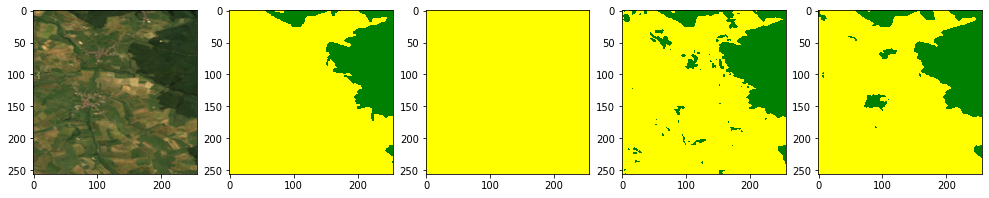

In [ ]:
# from ipywidgets import interact
from matplotlib import colors
# @interact(image_number=np.arange(0, 17, 1))
palette = ['006400',
           'FEFF99']
# make a color map of fixed colors
cmap = colors.ListedColormap(['yellow', 'green'])
bounds=[0.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

def plot_prediction(image_number):
    fig = plt.figure(figsize=(17,7))
    
    plt.subplot(1, 5, 1)
    plt.imshow(np.flip(images[image_number, :, : , 1:4], axis=2)*5)
    
    plt.subplot(1, 5, 2)
    plt.imshow(labels[image_number,:,:,0], cmap=cmap)

    plt.subplot(1, 5, 3)
    plt.imshow(featured_predictions_initial_model[image_number,:,:,0], cmap=cmap)

    plt.subplot(1, 5, 4)
    plt.imshow(featured_predictions_adam_crossentropy[image_number,:,:,0], cmap=cmap)

    plt.subplot(1, 5, 5)
    plt.imshow(featured_predictions_tversky_model[image_number,:,:,0], cmap=cmap)
    #miou.reset_state
    #miou.update_state(labels[image_number,:,:,0], featured_predictions[image_number,:,:,0])
    #print(miou.result())
    
plot_prediction(2)

In [ ]:
def prediction(repeat_dataset):
  images , labels = iter(repeat_dataset.take(1)).next()

  predictions = model_pretrained.predict(images, verbose=1)
  featured_predictions = np.where(predictions>0.5,1,predictions)
  featured_predictions = np.where(featured_predictions<0.5,0,featured_predictions)

  return np.flip(images, axis=2), labels, featured_predictions

# Compute forest evolution

In [ ]:
from forest_guard.parse import get_dataset, target_simplification

In [ ]:
def get_training_dataset_numpy(folder):
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    glob = 'gs://' + BUCKET + '/' + folder + '/' + TRAINING_BASE + '*'
    dataset = get_dataset(glob)
    dataset = dataset.map(target_simplification)

    feature = np.array([x for x, y in dataset])
    target = np.array([y for x, y in dataset])
    
    return feature, target

In [ ]:
image_data_2 = get_training_dataset_numpy(FOLDER)

In [ ]:
image_data_2[0].shape

(1000, 256, 256, 9)

In [ ]:
task = ee.batch.Export.table.toCloudStorage(
                                            collection = ee.FeatureCollection([]),
                                            description = desc,
                                            bucket = BUCKET,
                                            fileNamePrefix = folder + '/' + desc,
                                            fileFormat = 'TFRecord',
                                            selectors = BANDS + [RESPONSE], 
                                            )
task.start() 

# ee.Predict

In [ ]:
MODEL_DIR = 'gs://forest_guard_bucket/models/forest_guard/JP_test_model_adam_binarycrossentropy'
EEIFIED_DIR = 'gs://forest_guard_bucket/models/forest_guard/eefied'
REGION = 'europe-west1'

In [ ]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def(MODEL_DIR, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
  input_name = v.name
  break

output_name = None
for k,v in outputs.items():
  output_name = v.name
  break

# Make a dictionary that maps Earth Engine outputs and inputs to 
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: "fnf"}) + "'"

In [ ]:
PROJECT = 'wagon-bootcamp-data'

In [ ]:
# You need to set the project before using the model prepare command.

!earthengine set_project {PROJECT}
!earthengine model prepare --source_dir {MODEL_DIR} --dest_dir {EEIFIED_DIR} --input {input_dict} --output {output_dict}

Instructions for updating:
non-resource variables are not supported in the long term
Successfully saved project id
Instructions for updating:
non-resource variables are not supported in the long term
Success: model at 'gs://forest_guard_bucket/models/forest_guard/eefied' is ready to be hosted in AI Platform.


In [ ]:
%%writefile config.yaml
# autoScaling:
    # minNodes: 10

Overwriting config.yaml


In [ ]:
MODEL_NAME = 'JP_test_model_adam_binarycrossentropy'
PROJECT = 'wagon-bootcamp-data'
REGION = 'europe-west1'

In [ ]:
VERSION_NAME = 'v' + str(int(time.time()))
print('Creating version: ' + VERSION_NAME)

# !gcloud ai-platform models create {MODEL_NAME} \
#   --project {PROJECT} \
#   --region {REGION}

!gcloud ai-platform versions create {VERSION_NAME} \
  --project {PROJECT} \
  --model {MODEL_NAME} \
  --region {REGION} \
  --origin {EEIFIED_DIR} \
  --framework "TENSORFLOW" \
  --runtime-version 2.3 \
  --python-version 3.7 \
  #--machine-type mls1-c4-m2

  #--config=config.yaml \
  

Creating version: v1622563893
Using endpoint [https://europe-west1-ml.googleapis.com/]


# Prediction in Follium only

In [ ]:
MODEL_NAME_SMALL = 'JP_test_model_adam_binarycrossentropy'
VERSION_SMALL = "v1622718569"
MODEL_NAME_LARGE = 'adam_binary_tf_none_none'
VERSION_LARGE = 'v1622619546'
PROJECT = 'wagon-bootcamp-data'
REGION = 'us-central1'
# REGION = 'europe-west1'

In [ ]:
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True,
      show=False,
      opacity=0.7
  ).add_to(self)

# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(OPTICAL_BANDS).gt(0).And(
          image.select(OPTICAL_BANDS).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(OPTICAL_BANDS).divide(10000).addBands(
          image.select(THERMAL_BANDS).divide(10).clamp(273.15, 373.15)
            .subtract(273.15).divide(100)).updateMask(mask)


In [ ]:
folium.Map.add_ee_layer = add_ee_layer

def map_pred(year1=2017, year2=2020, model_large=False, center_point=[48.47, 6.92], zoom_start=13):
  '''
  plot on follium landsat on year1 and year2
  '''
  threshold = 0.80
  #max year is 2020
  if year2>2020:
    year2=2020
  if year1>2020:
    year1=2020

  #min year is 2013
  if year2<2013:
    year2=2013
  if year1<2013:
    year1=2013

  # Use Landsat 8 surface reflectance data.
  l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')


  if model_large:
    MODEL_NAME = MODEL_NAME_LARGE
    VERSION_NAME = VERSION_LARGE
  else:
    MODEL_NAME = MODEL_NAME_SMALL
    VERSION_NAME = VERSION_SMALL

  # The image input data is a cloud-masked median composite.
  image20 = l8sr.filterDate(
      f'{year2}-01-01', f'{year2}-12-31').map(maskL8sr).median().select(BANDS).float()
  image17 = l8sr.filterDate(
      f'{year1}-01-01', f'{year1}-12-31').map(maskL8sr).median().select(BANDS).float()


  # Load the trained model and use it for prediction.  If you specified a region 
  # other than the default (us-central1) at model creation, specify it here.
  model = ee.Model.fromAiPlatformPredictor(
      projectId = PROJECT,
      modelName = MODEL_NAME,
      version = VERSION_NAME,
      region= REGION,
      inputTileSize = [144, 144],
      inputOverlapSize = [8, 8],
      proj = ee.Projection('EPSG:4326').atScale(30),
      fixInputProj = True,
      outputBands = {'fnf': {
          'type': ee.PixelType.float()
        }
      }
  )



  # Use folium to visualize the input imagery and the predictions.
  map = folium.Map(location=center_point, zoom_start=zoom_start)
  


  ## landsat
  mapid = image17.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
  folium.TileLayer(
      tiles=mapid['tile_fetcher'].url_format,
      attr='Google Earth Engine',
      overlay=True,
      name=f'landsat{year1}',
      show=False
    ).add_to(map)

  mapid = image20.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
  folium.TileLayer(
      tiles=mapid['tile_fetcher'].url_format,
      attr='Google Earth Engine',
      overlay=True,
      name=f'landsat{year2}',
      show=False
    ).add_to(map)

  ### Predictions
  palette = [ '#FEFF99',
            '006400',
            ]
  #Pred year1
  predictions17 = model.predictImage(image17.toArray())
  predictions17=predictions17.where(predictions17.gt(threshold), 1)
  predictions17=predictions17.where(predictions17.lt(threshold), 0)

  mask_pred17 = predictions17.updateMask(predictions17.gte(threshold))

  map.add_ee_layer(mask_pred17,
                  {'bands': ['fnf'],
                        'min': 1, 
                        'max': 1, 
                        'palette':palette
                        }, f'predictions_{year1}'
                  )
  
  #PRED year2
  predictions20 = model.predictImage(image20.toArray())
  predictions20=predictions20.where(predictions20.gt(threshold), 1)
  predictions20=predictions20.where(predictions20.lt(threshold), 0)
  
  mask_pred20 = predictions20.updateMask(predictions20.gte(threshold))

  map.add_ee_layer(mask_pred20,
                  {'bands': ['fnf'],
                        'min': 1, 
                        'max': 1, 
                        'palette':palette
                        }, f'predictions_{year2}'
                  )
  #Diff of prediction
  palette_diff = [ 'red','blue']

  
  diff = predictions20.subtract(predictions17)
  d_map = predictions20.multiply(0)
  d_map = d_map.where(diff.gt(0.6), 2)      # All pos diffs are now labeled 2.
  d_map = d_map.where(diff.lt(-0.6), 1)      # Label all neg to 1.
  mask_d_map = d_map.updateMask(d_map.gte(0.5)) #mask the zeros


  map.add_ee_layer(mask_d_map,
                  {'bands': ['fnf'],
                        'min': 1, 
                        'max': 2, 
                        'palette':palette_diff
                        }, f'predictions_diff_{year2}_{year1}'
                  )

  ###JAXA
  from forest_guard.datas import get_jaxa
  jaxa = get_jaxa('2017-01-01', '2017-12-31')

  palette = ['006400',
            'FEFF99',
              '0000FF'
            ]
  mask_pred_jaxa = jaxa.updateMask(jaxa.lte(1.5))

  map.add_ee_layer(mask_pred_jaxa,
                  {'bands': ['fnf'],
                        'min': 1, 
                        'max': 3, 
                        'palette':palette
                        }, 'jaxa_masked'
                  )

  #### SHOW MAP
  map.add_child(folium.LayerControl())

  display(map)
  return map

In [ ]:
map = map_pred(2017, 2020, model_large=False)

In [ ]:
map.__dict__['_parent'].__dict__['html'].__dict__['_env'].__dict__

{'auto_reload': True,
 'autoescape': False,
 'block_end_string': '%}',
 'block_start_string': '{%',
 'bytecode_cache': None,
 'cache': <LRUCache {(<weakref at 0x7fae5b69c5f0; to 'PackageLoader' at 0x7fae5b742110>, 'color_scale.js'): <Template 'color_scale.js'>}>,
 'comment_end_string': '#}',
 'comment_start_string': '{#',
 'enable_async': False,
 'extensions': {},
 'filters': {'abs': <function abs>,
  'attr': <function jinja2.filters.do_attr>,
  'batch': <function jinja2.filters.do_batch>,
  'capitalize': <function jinja2.filters.do_capitalize>,
  'center': <function jinja2.filters.do_center>,
  'count': <function len>,
  'd': <function jinja2.filters.do_default>,
  'default': <function jinja2.filters.do_default>,
  'dictsort': <function jinja2.filters.do_dictsort>,
  'e': <function markupsafe._speedups.escape>,
  'escape': <function markupsafe._speedups.escape>,
  'filesizeformat': <function jinja2.filters.do_filesizeformat>,
  'first': <function jinja2.filters.do_first>,
  'float': <

In [ ]:
map.get_Zoom()

AttributeError: ignored

In [ ]:
1/6


0.16666666666666666